In [1]:
#example

# Example: Detailed MNIST (with custom code)

> This example is totally overkill for MNIST, but it explains how you would use leanai on your problem.

In this example we will have a look at how to implement all the details of MNIST.
For MNIST, this will be totally overkill, but it is a nice simple example to teach all details.
At the end of this tutorial, you should feel comfortable to implement your own task using MNIST without any trouble.

> **Note**: This tutorial will assume, that you have already completed the Minimal MNIST tutorial.


## Structure

We will implement everything step by step in this notebook.
Each section could be it's own python file or package if it gets more complicated, so keep that in mind.

1. Dataset
2. Model
3. Training/Loss

## Dataset

First we will implement a `SimpleDataset`. The `SimpleDataset` provides us with samples to use for training and validation. Each sample is a tuple that has two entries, the first is the input to the model and the other is the output of the model. As these entries are often a general format related to the dataset, we will call them `DatasetInput` and `DatasetOutput`. In this case they are the same as the `NetworkInput` and `NetworkOutput`, but sometimes you will need transformers to convert the format.

So with that explanation, let's define a DatasetInput and DatasetOutput.

In [2]:
from collections import namedtuple

MNISTInputType = namedtuple("MNISTInput", ["image"])
MNISTOutputType = namedtuple("MNISTOutput", ["class_id"])

Next we will implement our dataset by inheriting from `SimpleDataset`. This means we will only need to implement the constructor, where we set the sample tokens and getters for every field that was usesd in the Input and Output. Calling the getters and assembling the Types is automatically done by the parent class.

**Sample Tokens** are a list of indentifiers (str/int) used to uniquely identify a sample in a dataset. The list that is set initially must contain all examples that are used during training.

**Getters** are `get_image` and `get_class_id` in this example and return the respective data associated to the provided sample token.

In [3]:
from typing import Any
import numpy as np
from collections import namedtuple
from torchvision.datasets import FashionMNIST
from leanai.core.definitions import SPLIT_TRAIN
from leanai.data.dataset import SimpleDataset


class FashionMNISTDataset(SimpleDataset):
    def __init__(self, split: str, data_path: str = "", download=True, shuffle=True) -> None:
        super().__init__(
            InputType=MNISTInputType,
            OutputType=MNISTOutputType,
        )
        self.dataset = FashionMNIST(data_path, train=split == SPLIT_TRAIN, download=download)
        # Provide a list with all sample_tokens
        self.set_sample_tokens(range(len(self.dataset)))

    def get_image(self, sample_token) -> Any:
        image, _ = self.dataset[sample_token]
        image = np.array(image, dtype="float32")
        return np.reshape(image, (28, 28, 1))

    def get_class_id(self, sample_token) -> Any:
        _, class_id = self.dataset[sample_token]
        return np.array([class_id], dtype="uint8")

Let's see the output.

(28, 28, 1)
(1,)


/home/fuerst/.miniconda3/envs/ssf/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


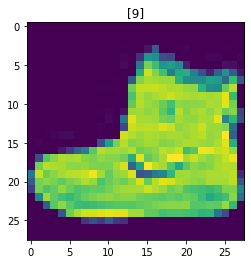

In [4]:
import matplotlib.pyplot as plt

debug_dataset = FashionMNISTDataset("train", "outputs")
feature, target = debug_dataset[0]
print(feature.image.shape)
print(target.class_id.shape)

plt.imshow(feature.image[:, :, 0])
plt.title(target.class_id)
plt.show()

Looks as expected, let's move on.

## Model

Now with a dataset implemented, let's implement our model.
The model can be any pytorch model inheriting from (`torch.nn.Module`).

However, you can also write models using layers from leanai, for a bit more keras like feeling.
Let me show you how.

Generally, we have to create our layers in the constructor and then implement the forward. That is it.

In [5]:
import torch.nn as nn
from leanai.model.layers import Conv2D, Flatten, Dense, ImageConversion, Activation, Sequential, BatchNormalization, MaxPooling2D


class ImageClassifierSimple(nn.Module):
    def __init__(self, num_classes=10, logits=False):
        super().__init__()
        layers = [
            ImageConversion(standardize=False, to_channel_first=True),
            Conv2D(kernel_size=(3, 3), filters=12),
            Activation("relu"),
            MaxPooling2D(),
            BatchNormalization(),
            Conv2D(kernel_size=(3, 3), filters=18),
            Activation("relu"),
            MaxPooling2D(),
            BatchNormalization(),
            Conv2D(kernel_size=(3, 3), filters=18),
            Activation("relu"),
            MaxPooling2D(),
            BatchNormalization(),
            Conv2D(kernel_size=(3, 3), filters=18),
            Activation("relu"),
            MaxPooling2D(),
            BatchNormalization(),
            Flatten(),
            Dense(18),
            Activation("relu"),
            Dense(num_classes),
        ]
        if not logits:
            layers.append(Activation("softmax", dim=1))
        self.layers = Sequential(*layers)

    def forward(self, image):
        return self.layers(image)

# Training / Loss

Next stop is implementing a custom loss, to tie everything together.

For losses again any pytorch loss will work fine, but we will implement a leanai loss, as it comes with additional logging capabilities.
Anywhere in your loss function you can simply call `self.log(name, scalar)` and it will add it to the tensorboard logging.

Your loss is implemented again by implementing the `__init__` and the `forward` method.

In [6]:
from leanai.core.experiment import Experiment
from leanai.training.losses import SparseCrossEntropyLossFromLogits, Loss


class MyLoss(Loss):
    def __init__(self, parent: Experiment):
        super().__init__(parent)
        self.loss = SparseCrossEntropyLossFromLogits()

    def forward(self, y_pred, y_true):
        loss = self.loss(y_pred=y_pred, y_true=y_true)
        self.log("loss/my_ce", loss)
        return loss

## Experiment

As we have explained how this works, let's just use the experiment to run a training with this dataset, model and loss.

In [7]:
import torch
from torch.optim import SGD
from leanai.core.experiment import Experiment, set_seeds


set_seeds()
experiment = Experiment(
    model=ImageClassifierSimple(num_classes=10, logits=True),
    output_path="outputs",
    example_input=torch.zeros((2, 28, 28, 1), dtype=torch.float32),
)
experiment.run_training(
    load_dataset=dict(
        type=FashionMNISTDataset,
        data_path="outputs",
    ),
    build_loss=dict(
        type=MyLoss
    ),
    build_optimizer=dict(
        type=SGD,
        lr=1e-3,
    ),
    batch_size=32,
    epochs=10,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/fuerst/.miniconda3/envs/ssf/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):

  | Name  | Type                  | Params | In sizes       | Out sizes
-----------------------------------------------------------------------------
0 | model | ImageClassifierSimple | 8.6 K  | [2, 28, 28, 1] | [2, 10]  
1 | loss  | MyLoss                | 0      | ?              | ?        
-----------------------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

> **Note**: Unfortunately the progress bar does not work properly in jupyter notebooks.

## Wrap-Up

That is it for the tutorial. You might want to have a look at tensorboard though. Here you go.

In [8]:
%load_ext tensorboard
%tensorboard --logdir outputs